# Notebook for Deep Learning Autoencoder Applied to NSL-KDD Dataset

## Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style = 'whitegrid')

import sys
sys.path.append('../')

from src.modeling import build_autoencoder, evaluate_autoencoder_model
from src.utils import plot_confusion, plot_precision_recall
from src.experiments import run_autoencoder_experiment

## Load Data

In [4]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

## Train on Normal Data Only

In [5]:
X_train_normal = X_train[y_train == 0]
print(f"Training on normal samples only: {X_train_normal.shape}")

Training on normal samples only: (53874, 33)


## Parameter Search Experiment

In [7]:
results = []
for dim in [8, 16, 32]:
    for dropout in [0.0, 0.1, 0.2]:
        metrics = run_autoencoder_experiment(
            X_train_normal = X_train_normal,
            X_test = X_test, 
            y_test = y_test, 
            encoding_dim = dim,
            dropout_rate = dropout,
            learning_rate = 1e-4,
            epochs = 100,
            threshold_percentile = 99,
            verbose = 0
        )
        results.append(metrics)

results_df = pd.DataFrame(results)
results_df.sort_values("f1", ascending = False)

,encoding_dim,dropout,lr,epochs_run,f1,recall,precision,accuracy,threshold
6,32,0.0,0.0001,43,0.803989,0.680710,0.981796,0.845525,0.375642
8,32,0.2,0.0001,40,0.799474,0.673887,0.982591,0.842667,0.358896
4,16,0.1,0.0001,37,0.563944,0.397493,0.970233,0.713911,0.520906
7,32,0.1,0.0001,35,0.507515,0.344107,0.966467,0.689184,0.477883
5,16,0.2,0.0001,31,0.341324,0.208255,0.945412,0.625918,0.625709
3,16,0.0,0.0001,20,0.302151,0.180283,0.932510,0.612423,0.858042
1,8,0.1,0.0001,23,0.271887,0.159304,0.927047,0.602897,1.350053
0,8,0.0,0.0001,25,0.199621,0.112315,0.896528,0.580830,1.193875
2,8,0.2,0.0001,41,0.175829,0.097646,0.882126,0.573963,1.178179


## Build Autoencoder

In [8]:
input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim, encoding_dim=32)
autoencoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 33)]              0         
                                                                 
 dense_72 (Dense)            (None, 64)                2176      
                                                                 
 batch_normalization_36 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_73 (Dense)            (None, 32)                2080      
                                                                 
 dense_74 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_37 (Bat  (None, 64)               256       
 chNormalization)                                         

## Train Autoencoder

Epoch 1/100
379/379 [==============================] - 3s 5ms/step - loss: 0.5941 - val_loss: 0.2509
Epoch 2/100
379/379 [==============================] - 2s 5ms/step - loss: 0.3447 - val_loss: 0.2086
Epoch 3/100
379/379 [==============================] - 2s 4ms/step - loss: 0.2869 - val_loss: 0.1704
Epoch 4/100
379/379 [==============================] - 2s 4ms/step - loss: 0.2570 - val_loss: 0.1729
Epoch 5/100
379/379 [==============================] - 1s 4ms/step - loss: 0.2319 - val_loss: 0.1901
Epoch 6/100
379/379 [==============================] - 1s 4ms/step - loss: 0.2107 - val_loss: 0.1973
Epoch 7/100
379/379 [==============================] - 2s 4ms/step - loss: 0.1965 - val_loss: 0.3816
Epoch 8/100
379/379 [==============================] - 2s 4ms/step - loss: 0.1860 - val_loss: 0.3566


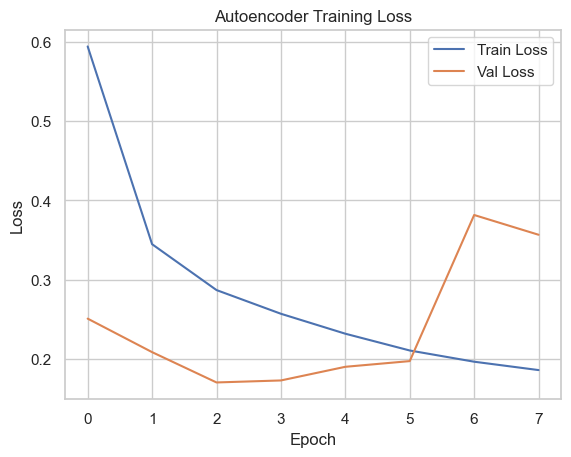

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs = 100,
    batch_size = 128,
    shuffle = True,
    validation_split = 0.1,
    verbose = 1,
    callbacks = [early_stop]
)

# Plot training loss
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.title("Autoencoder Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()
    

## Compute Reconstruction Errors and Tune Threshold

1684/1684 [==============================] - 3s 2ms/step
Threshold (99th Percentile):  0.37979
788/788 [==============================] - 1s 2ms/step


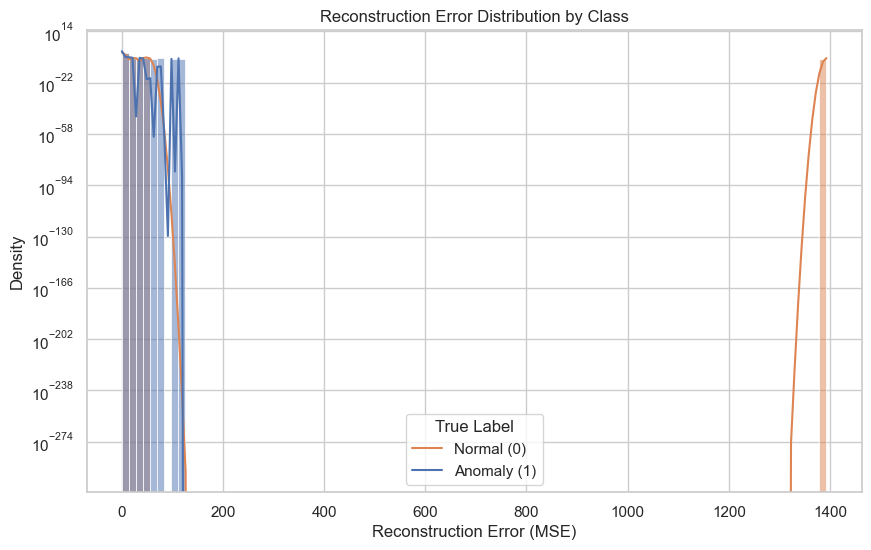

In [16]:
# get reconstruction errors for normal training data
X_train_recon = autoencoder.predict(X_train_normal)
train_recon_error = np.mean(np.square(X_train_normal - X_train_recon), axis = 1)

# Chose a threshold based on training distribution
threshold = np.percentile(train_recon_error, 99)
print(f"Threshold (99th Percentile): {threshold: .5f}")

# predict reconstructions
X_test_recon = autoencoder.predict(X_test)

# compute test reconstruction error
recon_error = np.mean(np.square(X_test - X_test_recon), axis = 1)
y_pred_ae = (recon_error > threshold).astype(int)

# build a dataframe to organize reconstruction errors and labels
df_errors = pd.DataFrame({
    'reconstruction_error': recon_error,
    'true_label': y_test
})

# Plot distribution
plt.figure(figsize = (10,6))
sns.histplot(data = df_errors,
             x = "reconstruction_error",
             hue = "true_label",
             bins = 100,
             kde = True,
            stat = "density", 
            common_norm = False)
plt.title("Reconstruction Error Distribution by Class")
plt.ylabel("Density")
plt.xlabel("Reconstruction Error (MSE)")
plt.yscale("log")
#plt.xlim(0, 50)
plt.legend(title = "True Label", labels = ["Normal (0)", "Anomaly (1)"])
plt.show()

In [17]:
print(df_errors.groupby("true_label")["reconstruction_error"].describe())

              count      mean        std       min       25%       50%  \
true_label                                                               
0           13469.0  0.126888   2.166967  0.002179  0.007060  0.014195   
1           11726.0  0.695404  12.932184  0.016954  0.327523  0.395921   

                 75%          max  
true_label                         
0           0.032623   112.679137  
1           0.523243  1393.127104  


## Evaluate Model

In [18]:
metrics_ae = evaluate_autoencoder_model(y_test, y_pred_ae)

print("Autoencoder Metrics:")
for k, v in metrics_ae.items():
    print(f"{k}: {v: .3f}")

Autoencoder Metrics:
accuracy:  0.776
precision:  0.977
recall:  0.531
f1:  0.688


## Visualizations

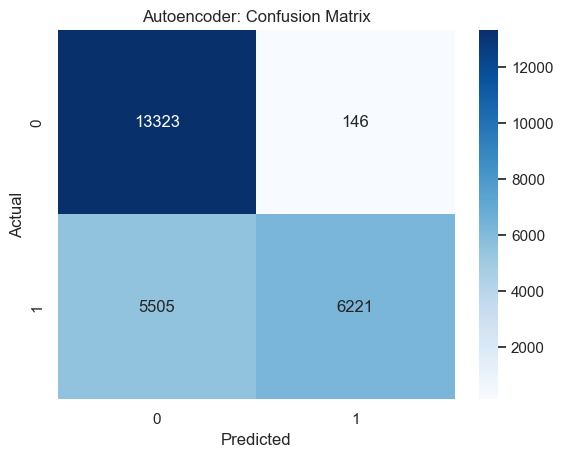

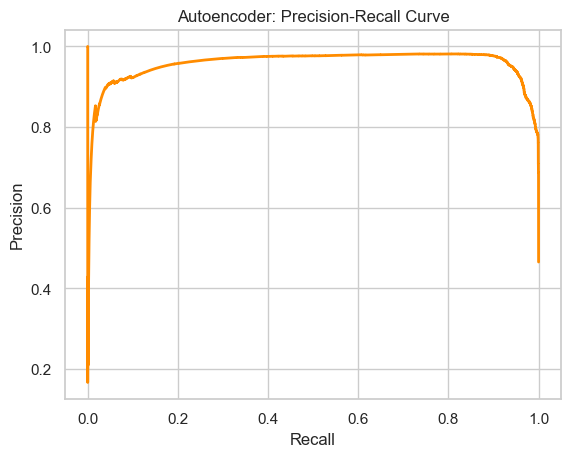

In [19]:
plot_confusion(y_test, y_pred_ae, title = "Autoencoder: Confusion Matrix")
plot_precision_recall(y_test, recon_error, title = "Autoencoder: Precision-Recall Curve")